In [65]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.multiprocessing as mp

In [66]:
# Do you have CUDA available?
torch.cuda.is_available()

True

In [67]:
# data (path)
dataset_name = '\dataset'
root = os.getcwd() + dataset_name

# data (img)
img_height = 720
img_width = 720
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs =  # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 1 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

SyntaxError: invalid syntax (2567853234.py, line 12)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

In [ ]:
# Define Loss
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [ ]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [ ]:
cuda = torch.cuda.is_available()
print(f'CUDA Availibility: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

CUDA Availibility: True


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [ ]:
G_AB.apply(temp_weights_init_normal)

ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPa

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [ ]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


import itertools

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

# n_epochs = 10
# epoch = 0
# decay_epoch = 5

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [ ]:
import os
import glob
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'\landscape-test')+'/*.*')[5:])
            self.files_B = sorted(glob.glob(os.path.join(root+'\paint-test')+'/*.*')[5:])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'\landscape-test')+'/*.*')[:5])
            self.files_B = sorted(glob.glob(os.path.join(root+'\paint-test')+'/*.*')[:5]) 

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_6472\1133124422.py:45: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize(int(img_height*1.12), Image.BICUBIC),
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=0 # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=0
)

In [ ]:
import matplotlib.pyplot as plt
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

In [ ]:
#temp_imgs = next(iter(val_dataloader))

In [ ]:
#G_AB.eval() # test mode 
#G_BA.eval() # test mode
#print(temp_imgs['A'].shape)
#print(temp_imgs['B'].shape)

In [ ]:
#temp_real_A = temp_imgs['A'].type(Tensor) # A : monet
#temp_fake_B = G_AB(temp_real_A).detach()
#temp_real_B = temp_imgs['B'].type(Tensor) # B : photo
#temp_fake_A = G_BA(temp_real_B).detach()

In [ ]:
#print(temp_real_A.shape)
#print(temp_fake_B.shape)
#print(temp_real_B.shape)
#print(temp_fake_A.shape)

In [ ]:
#temp_real_A = make_grid(temp_real_A, nrow=5, normalize=True)
#temp_real_B = make_grid(temp_real_B, nrow=5, normalize=True)
#temp_fake_A = make_grid(temp_fake_A, nrow=5, normalize=True)
#temp_fake_B = make_grid(temp_fake_B, nrow=5, normalize=True)

In [ ]:
#type(temp_real_A)

In [ ]:
#plt.imshow(temp_real_A.cpu().permute(1,2,0))
#plt.title('Real A')
#plt.axis('off');

In [ ]:
#print(temp_real_A.shape)
#print(temp_fake_B.shape)
#print(temp_real_B.shape)
#print(temp_fake_A.shape)

In [ ]:
#temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
#print(temp_image_grid.shape)

In [ ]:
#temp_image_grid.cpu().permute(1,2,0).shape

In [ ]:
#plt.imshow(temp_image_grid.cpu().permute(1,2,0))
#plt.title('Real A | Fake B | Real B | Fake A ')
#plt.axis('off');

In [ ]:
#temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
#print(temp_image_grid.shape)

In [ ]:
from tqdm import tqdm
import warnings

In [ ]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
# ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
# -----------------
# Show Progress
# -----------------
        if (i+1) % 50 == 0:
            # sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))



 55%|█████▍    | 50/91 [01:04<00:49,  1.21s/it]

[Epoch 1/2] [Batch 50/91] [D loss : 0.338064] [G loss : 7.533917 - (adv : 0.415620, cycle : 0.476426, identity : 0.470808)]


 55%|█████▍    | 50/91 [00:59<00:49,  1.20s/it]

[Epoch 2/2] [Batch 50/91] [D loss : 0.299758] [G loss : 5.631570 - (adv : 0.417721, cycle : 0.376555, identity : 0.289661)]


100%|██████████| 91/91 [01:48<00:00,  1.20s/it]


In [ ]:
torch.save(G_AB.state_dict(), 'land2paint.pth')

In [ ]:
torch.save(G_BA.state_dict(), 'paint2land.pth')

In [ ]:
torch.save(D_A.state_dict(), 'fakepaint2land.pth')

In [ ]:
torch.save(D_B.state_dict(), 'fakeland2paint.pth')

In [ ]:
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

G_AB.load_state_dict(torch.load('land2paint.pth'))
G_AB.cuda()
G_AB.eval()

G_BA.load_state_dict(torch.load('paint2land.pth'))
G_BA.cuda()
G_BA.eval()

D_A.load_state_dict(torch.load('fakepaint2land.pth'))
D_A.cuda()
D_A.eval()

D_B.load_state_dict(torch.load('fakeland2paint.pth'))
D_B.cuda()
D_B.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
for i, batch in enumerate(dataloader):
    # print('iter : {}  A.size : {}'.format(i,batch['A'].size()))
    # print('iter : {}  B.size : {}'.format(i,batch['B'].size()))
    if i == 10:
        break

In [ ]:

temp_A = batch['A'].cuda()
print(temp_A.type())
fake_B = G_AB(temp_A).detach()
fake_B = fake_B[0].cuda()
print(fake_B.size())

torch.cuda.FloatTensor
torch.Size([3, 720, 720])


torch.Size([3, 720, 720])


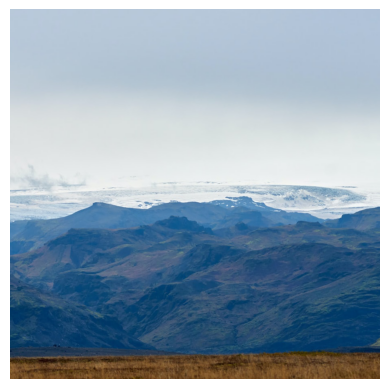

In [ ]:
temp_img = temp_A[0]
print(temp_img.size())

temp_img=(temp_img+1)/2
temp_img = temp_img.cpu().permute(1,2,0).numpy()
plt.imshow(temp_img)
plt.axis('off');

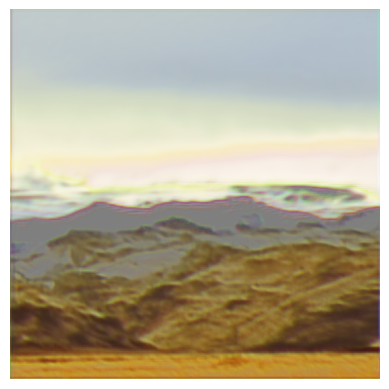

In [ ]:
temp_img = fake_B.squeeze()
G_AB.eval()
temp_img=(temp_img+1)/2
temp_img = temp_img.cpu().permute(1,2,0).numpy()
plt.imshow(temp_img)
plt.axis('off');

In [ ]:
temp_B = batch['B'].type(Tensor) # B
fake_A = G_BA(temp_B).detach()

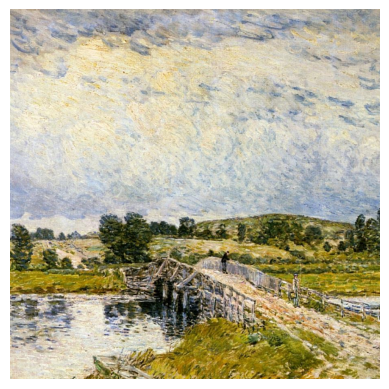

In [ ]:
temp_img = temp_B.squeeze()
G_BA.eval()
temp_img=(temp_img+1)/2
temp_img = temp_img.cpu().permute(1,2,0).numpy()
plt.imshow(temp_img)
plt.axis('off');

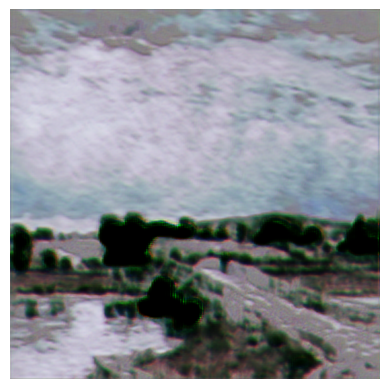

In [ ]:
temp_img = fake_A.squeeze()
G_BA.eval()
temp_img=(temp_img+1)/2
temp_img = temp_img.cpu().permute(1,2,0).numpy()
plt.imshow(temp_img)
plt.axis('off');

In [ ]:
D_A.output_shape

(1, 45, 45)

In [ ]:
temp_A.size()

torch.Size([1, 3, 720, 720])

In [ ]:
temp_A.size(0) # batch_size

1

In [ ]:
Tensor(np.ones((temp_A.size(0), *D_A.output_shape)))

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')

In [ ]:
Tensor(np.ones((temp_A.size(0), *D_A.output_shape))).shape

torch.Size([1, 1, 45, 45])

In [ ]:
# class Generator(nn.Module):
#     def __init__(self, d=128):
#         super(Generator, self).__init__()
#         self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
#         self.deconv1_bn = nn.BatchNorm2d(d*8)
#         self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
#         self.deconv2_bn = nn.BatchNorm2d(d*4)
#         self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
#         self.deconv3_bn = nn.BatchNorm2d(d*2)
#         self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
#         self.deconv4_bn = nn.BatchNorm2d(d)
#         self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

#     def forward(self, input):
#         # x = F.relu(self.deconv1(input))
#         x = F.relu(self.deconv1_bn(self.deconv1(input)))
#         x = F.relu(self.deconv2_bn(self.deconv2(x)))
#         x = F.relu(self.deconv3_bn(self.deconv3(x)))
#         x = F.relu(self.deconv4_bn(self.deconv4(x)))
#         x = torch.tanh(self.deconv5(x))

#         return x

# class Discriminator(nn.Module):
#     def __init__(self, d=128):
#         super(Discriminator, self).__init__()
#         self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
#         self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
#         self.conv2_bn = nn.BatchNorm2d(d*2)
#         self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
#         self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
#         self.conv4_bn = nn.BatchNorm2d(d*8)
#         self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

#     def forward(self, input):
#         x = F.leaky_relu(self.conv1(input), 0.2)
#         x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
#         x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
#         x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
#         x = torch.sigmoid(self.conv5(x))

#         return x

    
# generator = Generator()
# discriminator = Discriminator()

# device = torch.device("cuda:0" if True and torch.cuda.is_available() else "cpu")
# generator = generator.to(device)
# discriminator = discriminator.to(device)

# num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
# num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
# print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

In [ ]:
# # GAN training can be unstable. In this case, the strong momentum
# # for the gradient prevents convergence. One possible explanation is that the
# # strong momentum does not allow the two players in the adversarial game to react
# # to each other quickly enough. Decreasing beta1 (the exponential decay for the
# # gradient moving average in [0,1], lower is faster decay) from the default 0.9
# # to 0.5 allows for quicker reactions.
# gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# # set to training mode
# generator.train()
# discriminator.train()

# gen_loss_avg = []
# disc_loss_avg = []

# print('Training ...')
# for epoch in range(num_epochs):
#     gen_loss_avg.append(0)
#     disc_loss_avg.append(0)
#     num_batches = 0
    
#     for image_batch, _ in ltrain_dataloader:
        
#         # get dataset image and create real and fake labels for use in the loss
#         image_batch = image_batch.to(device)
#         label_real = torch.ones(image_batch.size(0), device=device)
#         label_fake = torch.zeros(image_batch.size(0), device=device)

#         # generate a batch of images from samples of the latent prior
#         latent = torch.randn(image_batch.size(0), 3, 400 , 400, device=device)
#         fake_image_batch = generator(latent)
        
#         # train discriminator to correctly classify real and fake
#         # (detach the computation graph of the generator and the discriminator,
#         # so that gradients are not backpropagated into the generator)
#         real_pred = discriminator(image_batch).squeeze()
#         fake_pred = discriminator(fake_image_batch.detach()).squeeze()
#         disc_loss = 0.5 * (
#             F.binary_cross_entropy(real_pred, label_real) +
#             F.binary_cross_entropy(fake_pred, label_fake))
        
#         disc_optimizer.zero_grad()
#         disc_loss.backward()
#         disc_optimizer.step()
        
#         # train generator to output an image that is classified as real
#         fake_pred = discriminator(fake_image_batch).squeeze()
#         gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
#         gen_optimizer.zero_grad()
#         gen_loss.backward()
#         gen_optimizer.step()
        
#         gen_loss_avg[-1] += gen_loss.item()
#         disc_loss_avg[-1] += disc_loss.item()
#         num_batches += 1
        
#     gen_loss_avg[-1] /= num_batches
#     disc_loss_avg[-1] /= num_batches
#     print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
#           (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))